In [27]:
import pandas as pd

cnvs = pd.read_csv('../analysis/merged_cnvs.txt', sep="\t", header=0, index_col=0, low_memory=False)
cnvs_genes = pd.read_csv('../analysis/merged_cnvs_genes.txt', sep="\t", header=0, index_col=0)

metasamples = pd.read_excel('../Metadata.xlsx')
metasamples['SAMPLE_ID'] = metasamples['SAMPLE_ID'].astype(str)
metasamples.index = [x.strip() for x in metasamples['SAMPLE_ID'] + '-' + metasamples['PATIENT_ID']]

In [28]:
# Keep only samples that are tumor-normal pair and labeled as included
meta_filtered = metasamples.loc[(metasamples['INCLUDED'] == "Y")
                                & (metasamples['TUMOR_ONLY'] == "No")
                                & (metasamples['SAMPLE_TYPE'] != "gDNA"), :]


# Filter CNVs and sort them by chromosome (remove X,Y chromosomes too)
cnvs = cnvs.loc[:, cnvs.columns[0:3].to_list() + list(meta_filtered.index)]
cnvs = cnvs.drop(['chrX', 'chrY'])
cnvs.index = [x.replace('chr','') for x in cnvs.index]
cnvs.index = cnvs.index.astype(int)
cnvs = cnvs.sort_index()

cnvs_genes = cnvs_genes.loc[:, list(meta_filtered.index)]
cnvs_genes = cnvs_genes.loc[[x for x in cnvs_genes.index if ';' not in x], :]

In [29]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.patches import Patch
import umap

figsize = (16,16) 
color_map = ["red", "green", "blue", "orange", "cyan", "yellow", "orchid", 
             "saddlebrown", "darkcyan", "gray", "darkred", "darkgreen", "darkblue", 
             "antiquewhite", "bisque", "black", "slategray", "gold", "floralwhite",
             "aliceblue", "plum", "cadetblue", "coral", "olive", "khaki", "lightsalmon"]

def plot_heatmap(data, meta, title, filename, col_cluster, row_cluster):
    
    meta = meta.reindex(data.index)

    var2 = meta['VAR2'].copy()
    var2.loc[var2 == 'E'] = color_map[1]
    var2.loc[var2 == 'F'] = color_map[2]
    var2.loc[var2.isna()] = color_map[0]
    var2_colors = var2.to_list()
    
    var4 = meta['VAR4'].copy()
    var4.loc[var4 == 'CR'] = color_map[4]
    var4.loc[var4 == 'PD'] = color_map[5]
    var4.loc[var4 == 'PR'] = color_map[6]
    var4.loc[var4 == 'long SD'] = color_map[7]
    var4.loc[var4 == 'short SD'] = color_map[8]
    var4.loc[var4.isna()] = color_map[0]
    var4_colors = var4.to_list()
    
    try:
        ax = sns.clustermap(data,
                            mask=data.isnull(),
                            z_score=None,
                            cmap=matplotlib.cm.bwr,
                            rasterized=True,
                            metric='euclidean',
                            method='complete',
                            yticklabels=1,
                            row_colors=[var2_colors, var4_colors],
                            col_cluster=col_cluster,
                            row_cluster=row_cluster,
                            vmax=np.nanmin(data),
                            vmin=np.nanmax(data))

        handles = [Patch(color=color_map[0], label='Na'),
                   Patch(color=color_map[1], label='E'),
                   Patch(color=color_map[2], label='F'),
                   Patch(color=color_map[4], label='CR'),
                   Patch(color=color_map[5], label='PD'),
                   Patch(color=color_map[6], label='PR'),
                   Patch(color=color_map[7], label='long SD'),
                   Patch(color=color_map[8], label='short SD')]
        ax.ax_heatmap.set_title(title, fontsize=12)
        ax.ax_heatmap.set_xlabel("Positions",fontsize=10)
        ax.ax_heatmap.set_ylabel("Samples", fontsize=10)
        ax.ax_heatmap.tick_params(labelsize=7)
        ax.cax.set_visible(True)
        ax.ax_row_dendrogram.legend(handles=handles, loc="upper left")
        ax.savefig(filename)
    except FloatingPointError:
        print('Could not compute distance metric')
    
def plot_scatter(x, y, colors, labels, title, filename):
    unique_colors = set(colors)
    color_values = [color_map[i] for i in unique_colors]
    colors = [color_map[i] for i in colors]

    fig, ax = plt.subplots(figsize=(12,12))
    sc = ax.scatter(x, 
                    y, 
                    c=colors, 
                    edgecolor="none", 
                    cmap=None, 
                    s=30)

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_title(title, size=14)
    ax.legend([plt.Line2D((0, 1), (0, 0), color=x) for x in color_values],
              labels, loc="upper right", markerscale=1.0,
              ncol=1, scatterpoints=1, fontsize=14)
    fig.savefig(filename)

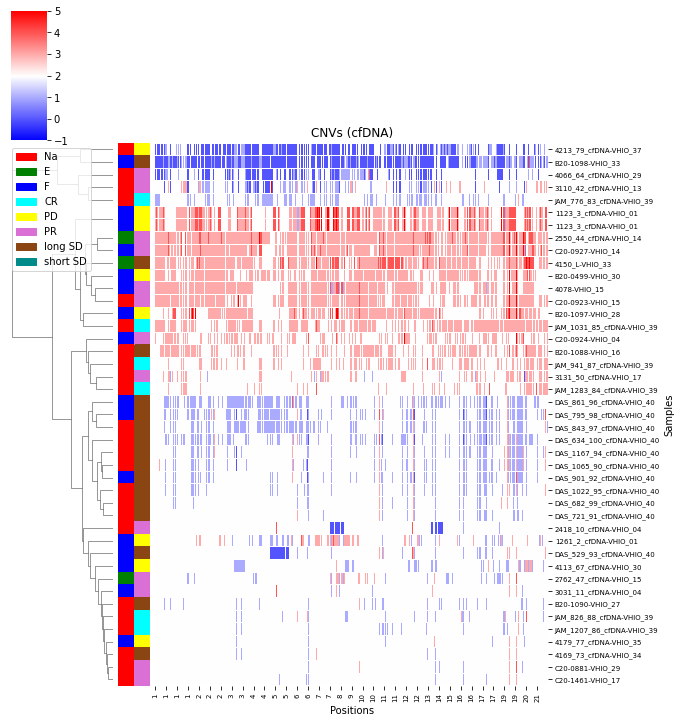

In [30]:
cfdna_samples = meta_filtered[(meta_filtered['SAMPLE_TYPE'] == "cfDNA")].index
cnvs_cfdna = cnvs.loc[:, cnvs.columns[0:2].to_list() + cfdna_samples.tolist()]
data = cnvs_cfdna.iloc[:,2:].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.dropna(how='all', axis=0)
data = data.dropna(how='all', axis=1)
data[data > 5.0] = 5
data = data.fillna(2)
name = 'CNVs (cfDNA)'
plot_heatmap(data, meta_filtered, name, name + "_scaled.pdf", False, True)

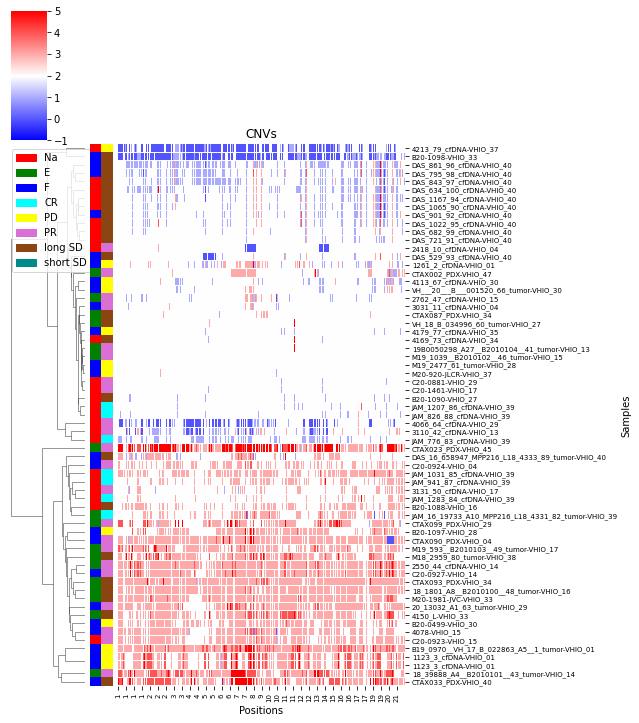

In [31]:
data = cnvs.iloc[:,2:].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.dropna(how='all', axis=0)
data = data.dropna(how='all', axis=1)
data[data > 5.0] = 5
data = data.fillna(2)
name = 'CNVs'
plot_heatmap(data, meta_filtered, name, name + "_scaled.pdf", False, True)

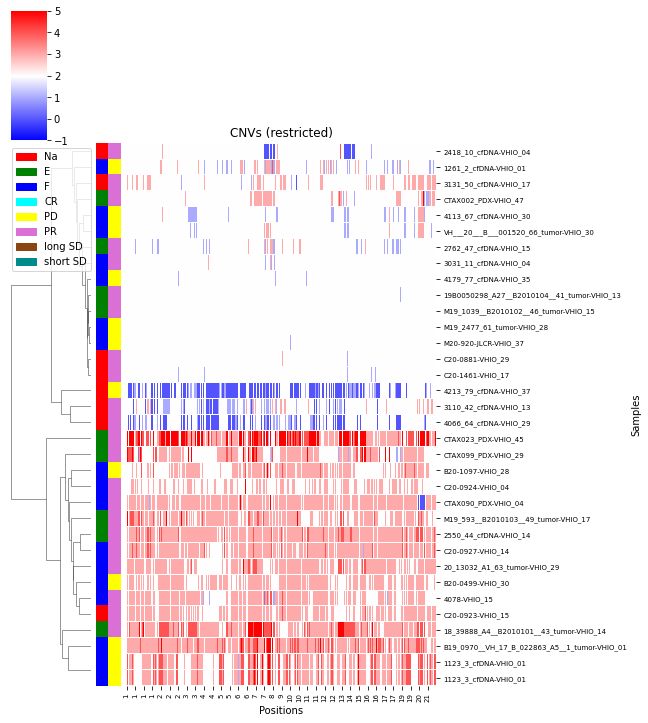

In [32]:
baseline_samples = meta_filtered[meta_filtered['VAR4'].isin(['PR', 'PD'])].index
cnvs_baseline = cnvs.loc[:, cnvs.columns[0:2].to_list() + baseline_samples.tolist()]
data = cnvs_baseline.iloc[:,2:].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.dropna(how='all', axis=0)
data = data.dropna(how='all', axis=1)
data[data > 5.0] = 5
data = data.fillna(2)
name = 'CNVs (restricted)'
plot_heatmap(data, meta_filtered, name, name + "_restricted.pdf", False, True)

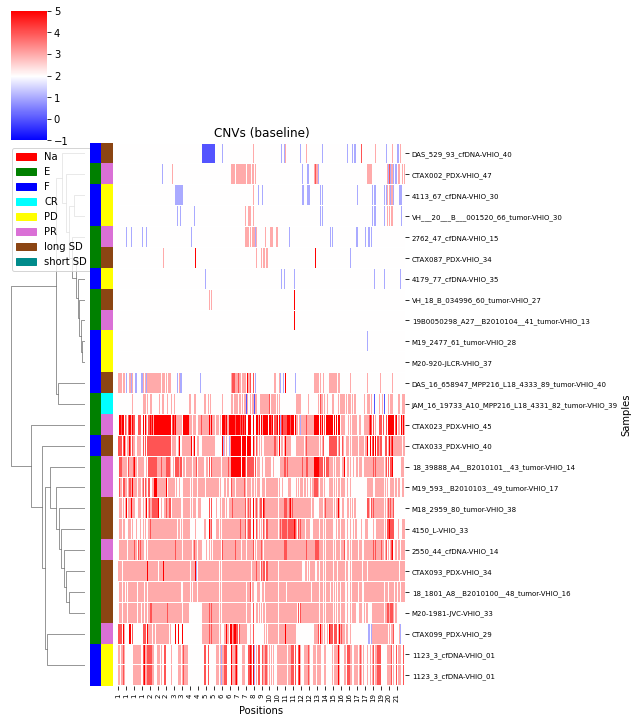

In [33]:
baseline_samples = meta_filtered[meta_filtered['baseline_1_more'] == "Y"].index
cnvs_baseline = cnvs.loc[:, cnvs.columns[0:2].to_list() + baseline_samples.tolist()]
data = cnvs_baseline.iloc[:,2:].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.dropna(how='all', axis=0)
data = data.dropna(how='all', axis=1)
data[data > 5.0] = 5
data = data.fillna(2)
name = 'CNVs (baseline)'
plot_heatmap(data, meta_filtered, name, name + "_scaled.pdf", False, True)

/Users/jfnavarro/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:810: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig = plt.figure(figsize=figsize)


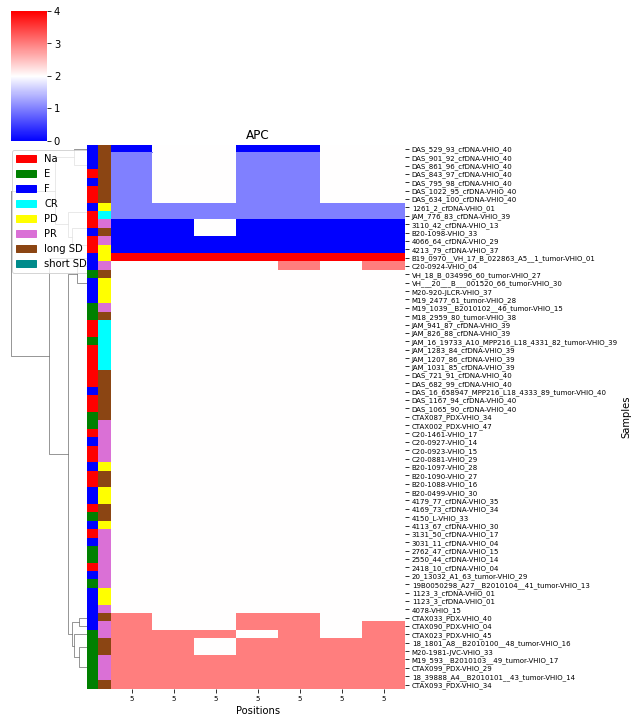

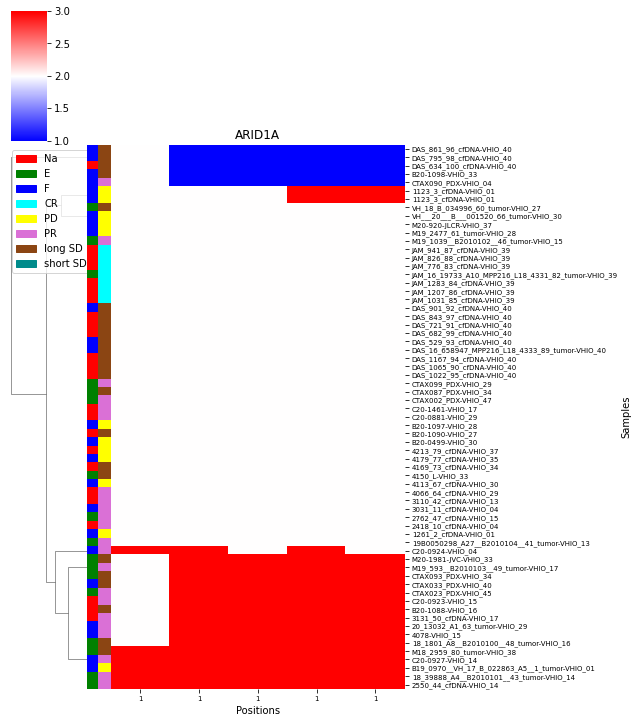

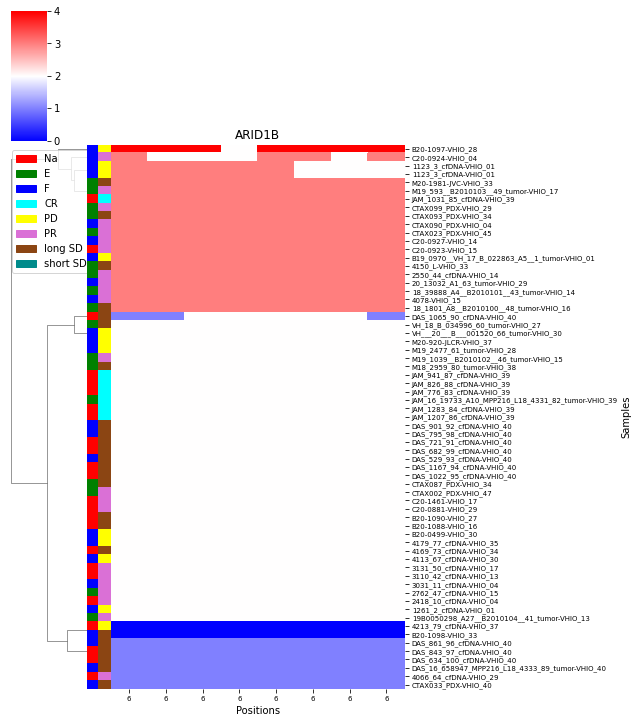

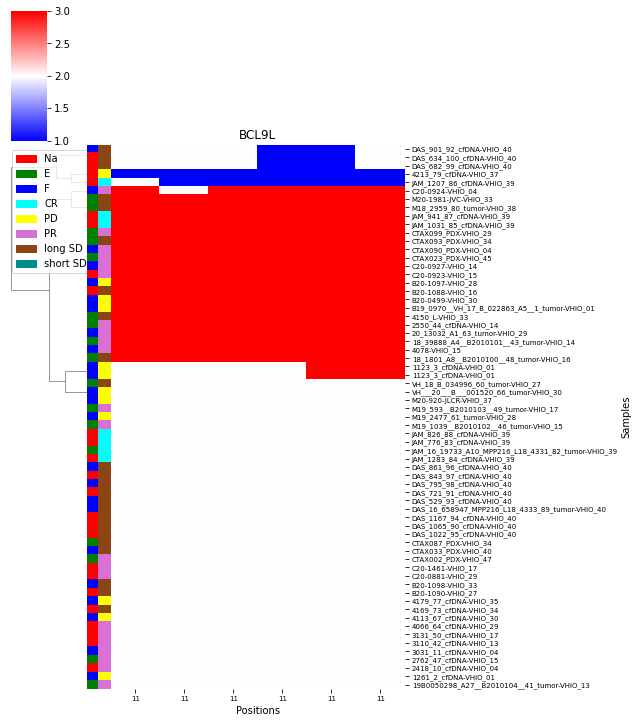

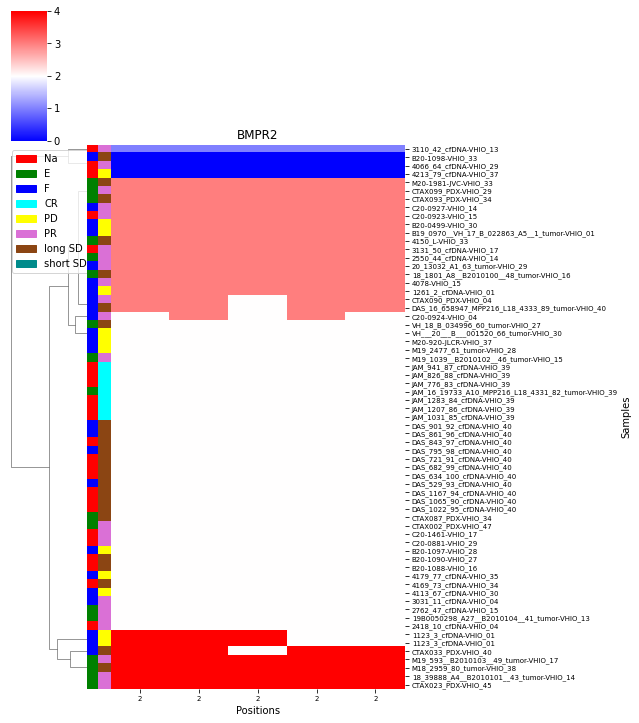

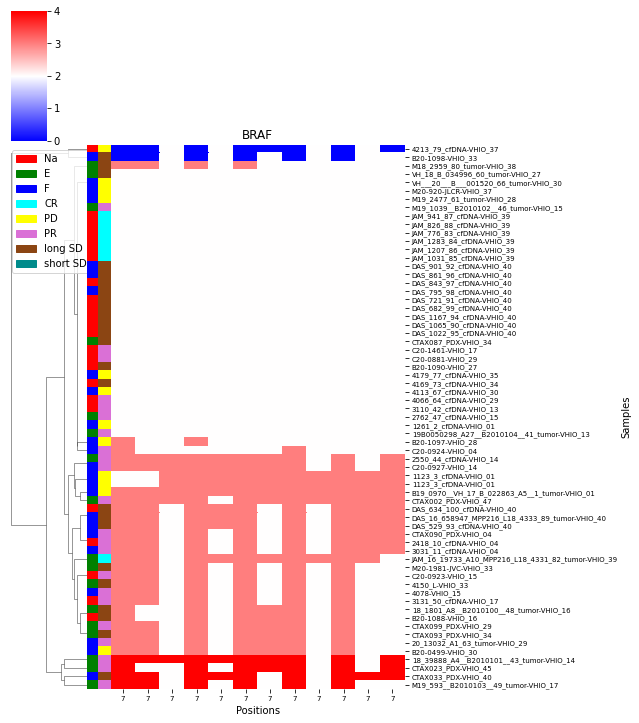

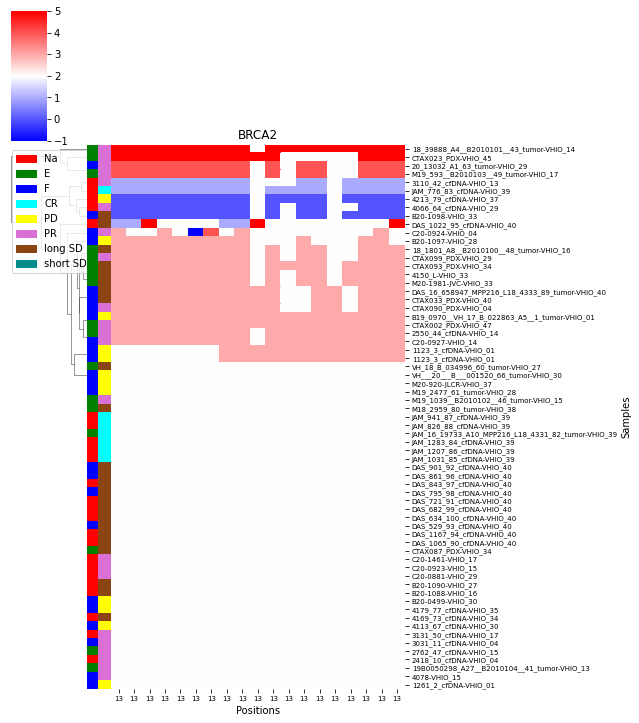

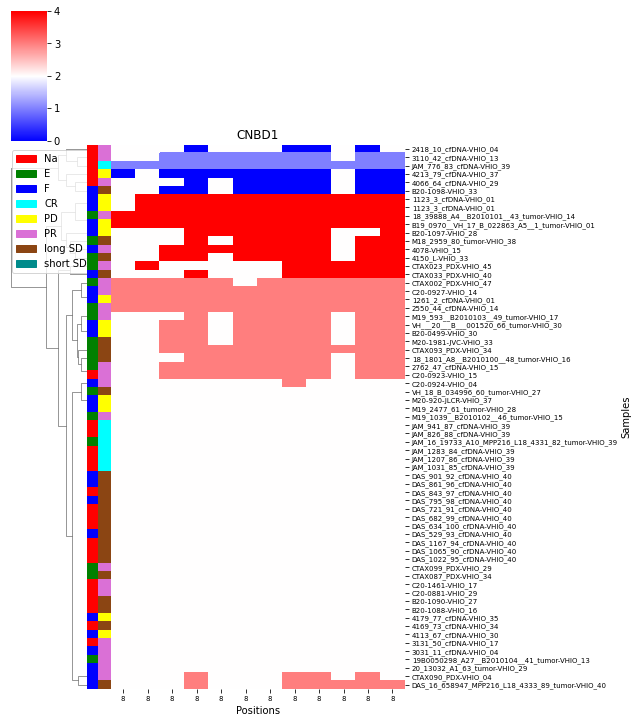

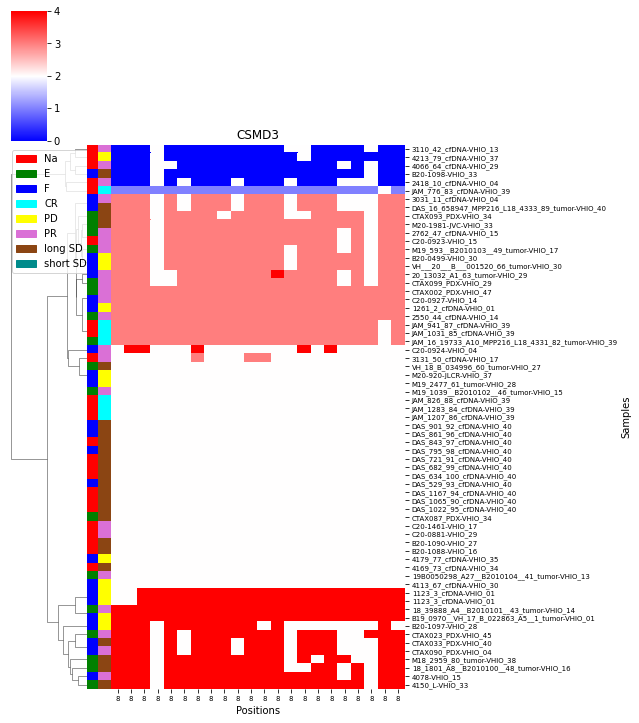

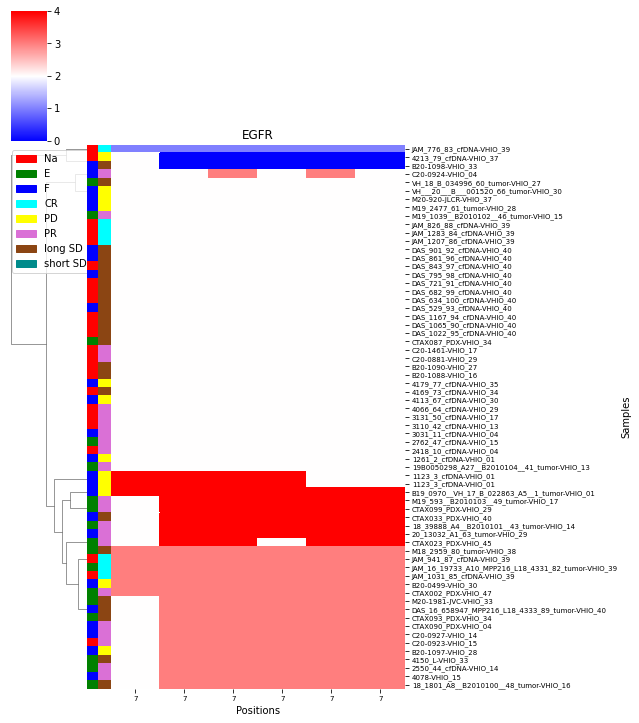

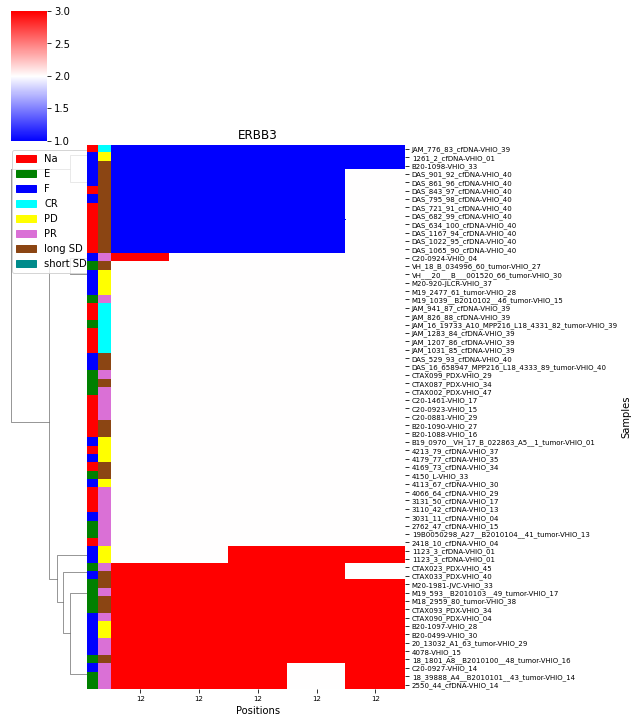

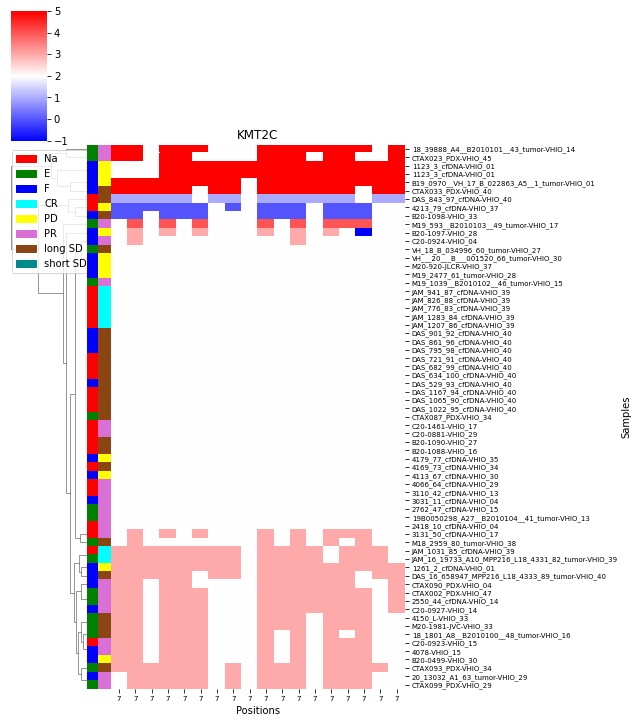

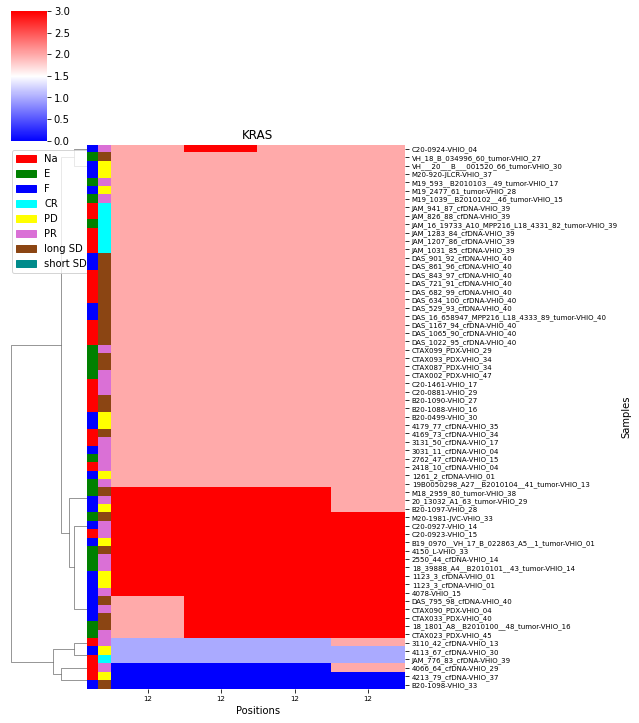

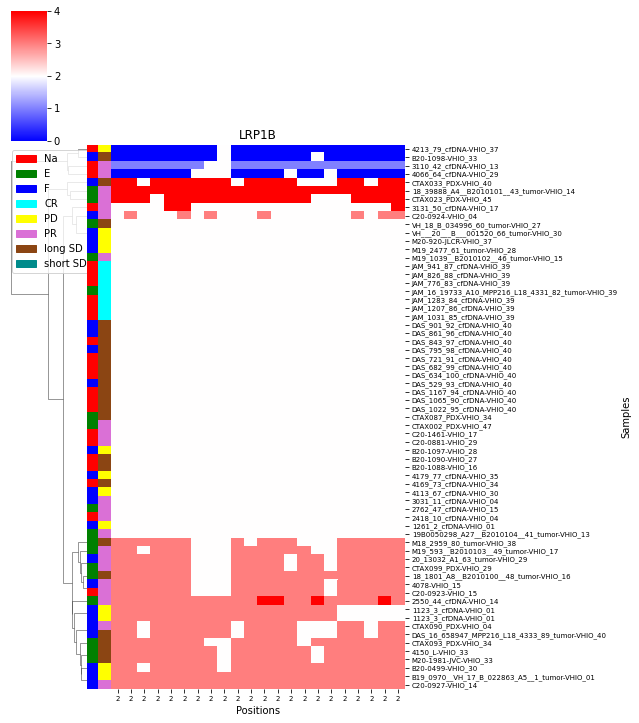

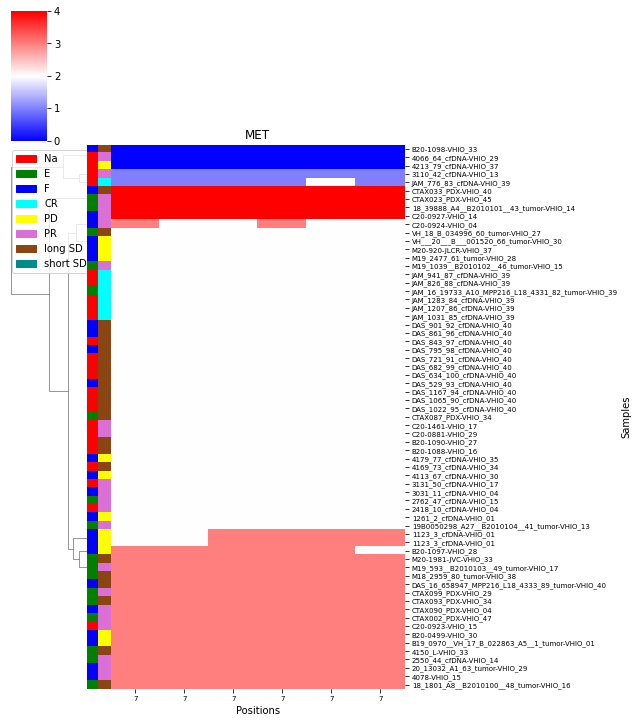

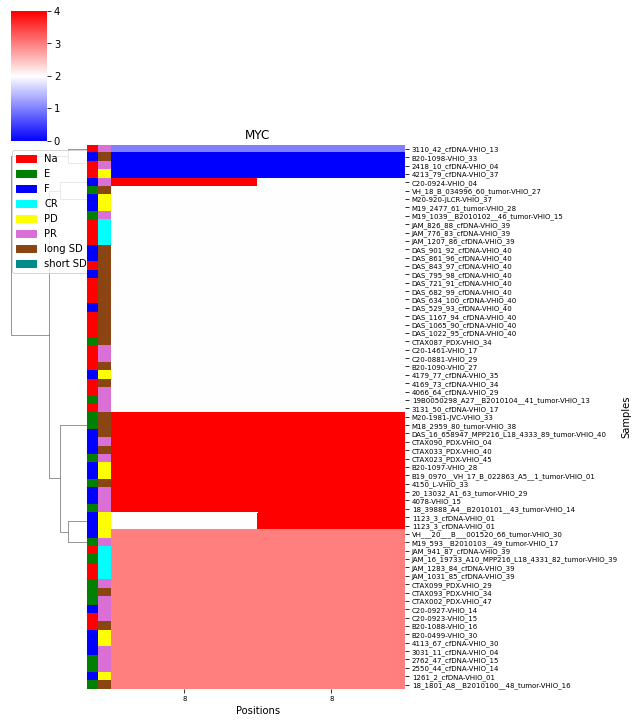

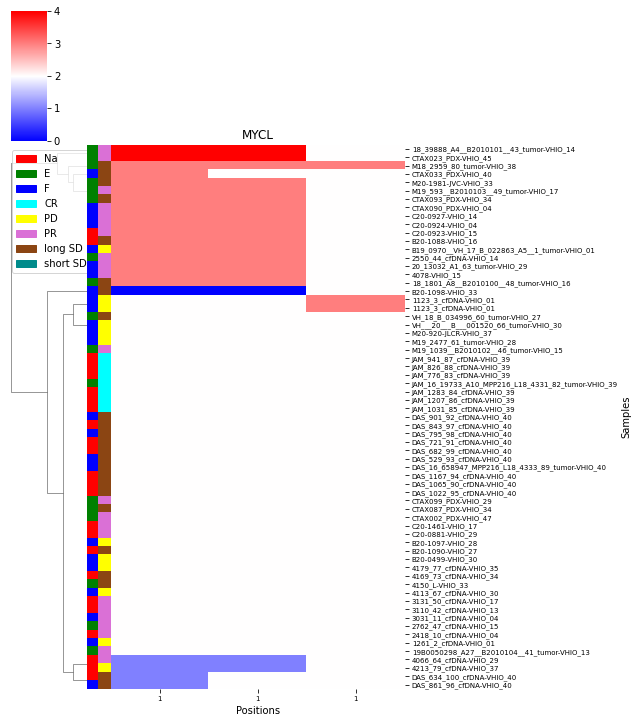

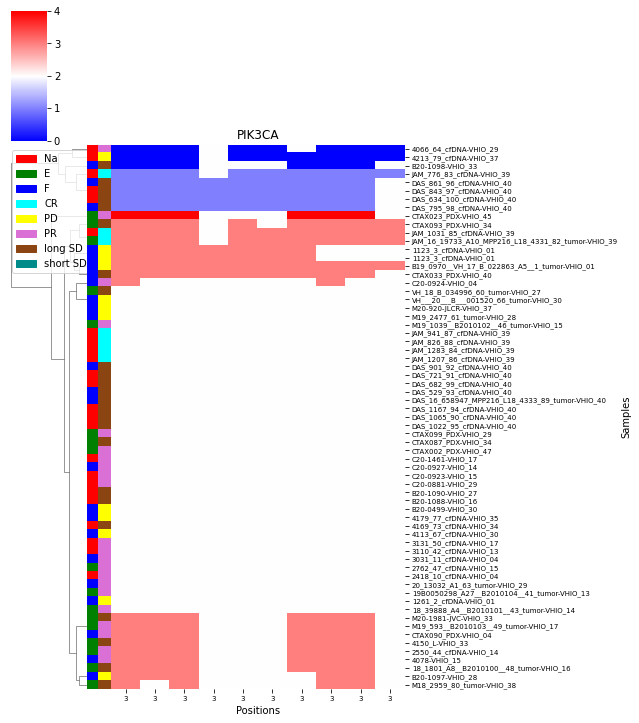

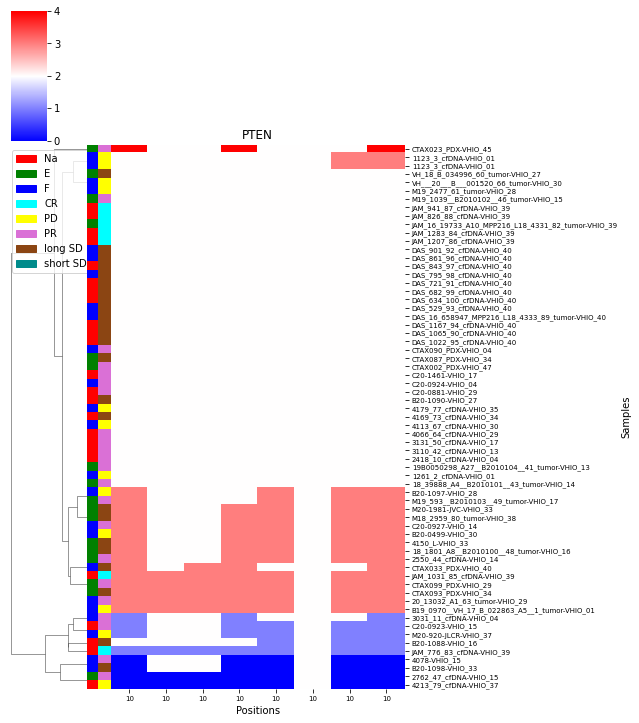

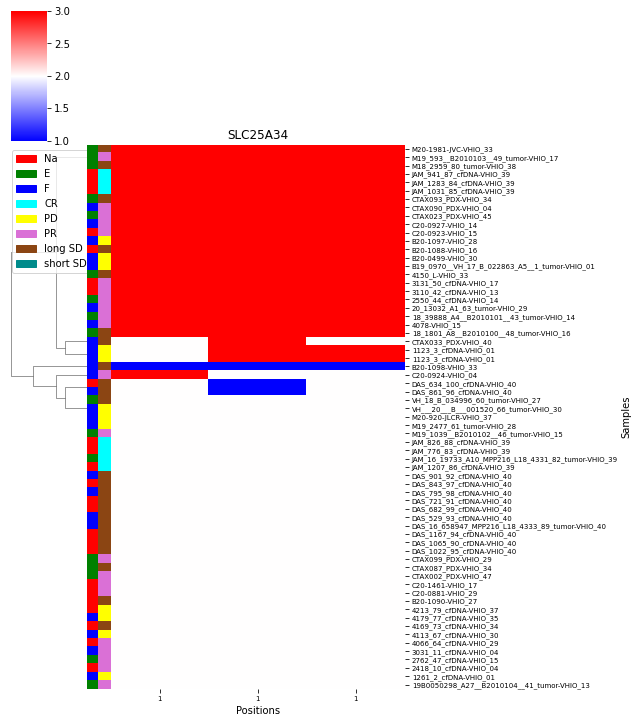

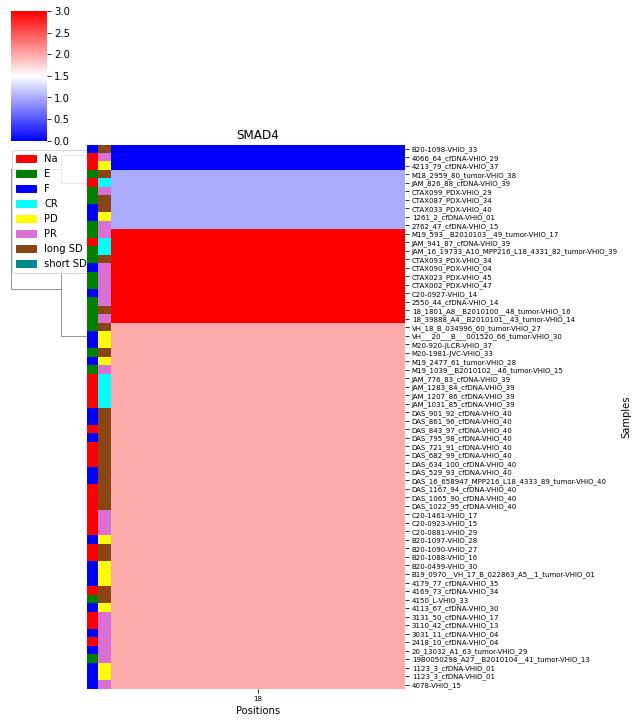

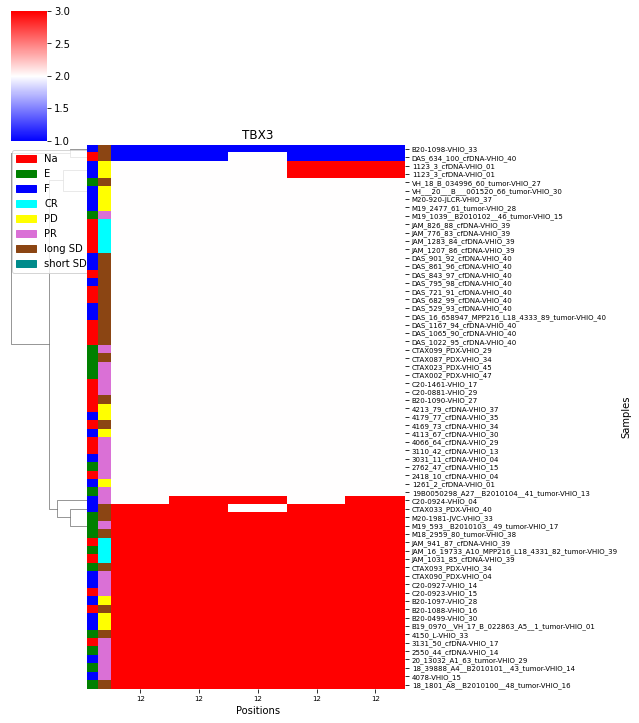

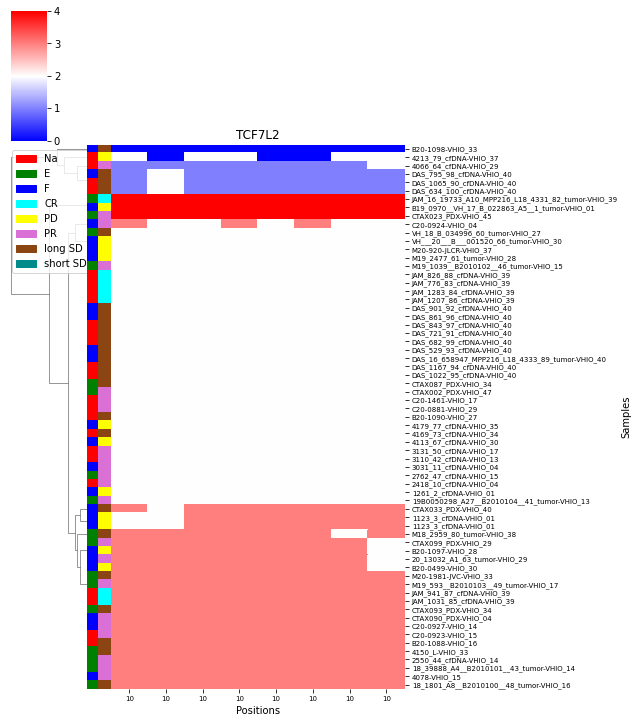

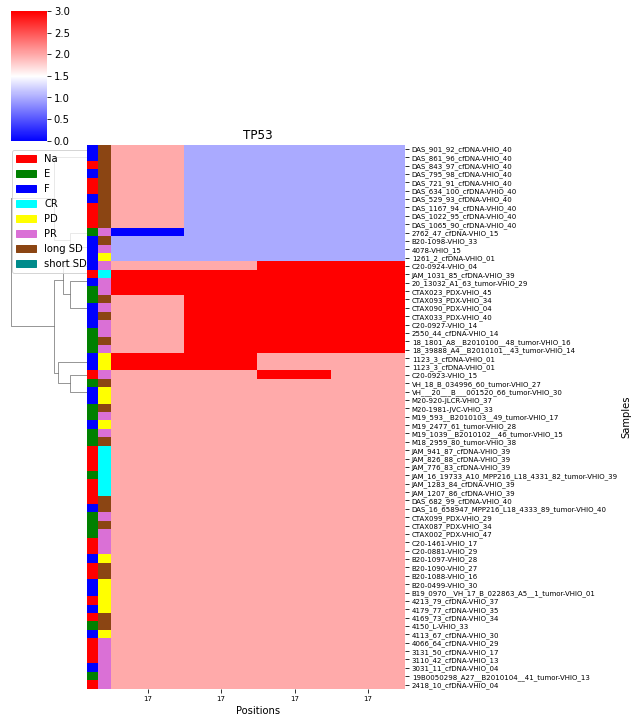

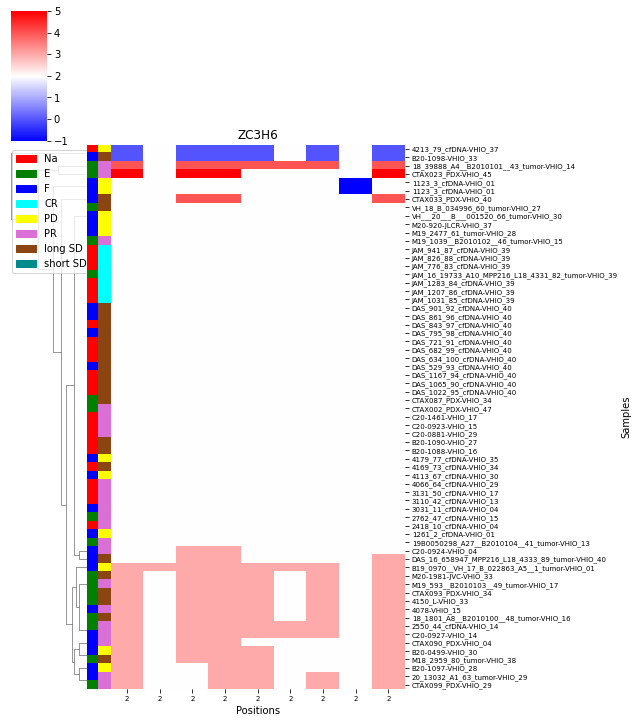

In [34]:
genes = ['APC', 'ARID1A', 'ARID1B', 'BCL9L', 'BCOR', 
         'BMPR2', 'BRAF', 'BRCA2', 'CNBD1', 'CSMD3', 
         'ERBB3', 'KMT2C', 'LRP1B', 'PIK3CA', 'PTEN',
         'RNF43', 'SLC25A34', 'SMAD4', 'TBX3', 'TCF7L2',
         'TP53', 'ZC3H6', 'MYC', 'MYCL', 'MET', 'EGFR',
         'BRAF', 'KRAS']
for name, group in cnvs.iloc[:,1:].groupby('GENE', axis=0):
    if name in genes:
        data = group.iloc[:,1:].transpose()
        data[data == 'Na'] = np.nan
        data = data.astype('float')
        data = data.dropna(how='all', axis=0)
        data = data.dropna(how='all', axis=1)
        min_value = np.nanmin(data.to_numpy())
        if min_value == -1:
            total = 5
        elif min_value == 0:
            total = 4
        else:
            total = 3
        data[data > total] = total
        data = data.fillna(2)
        data = data.T.drop_duplicates().T
        plot_heatmap(data, meta_filtered, name, name + "_scaled.pdf", False, True)

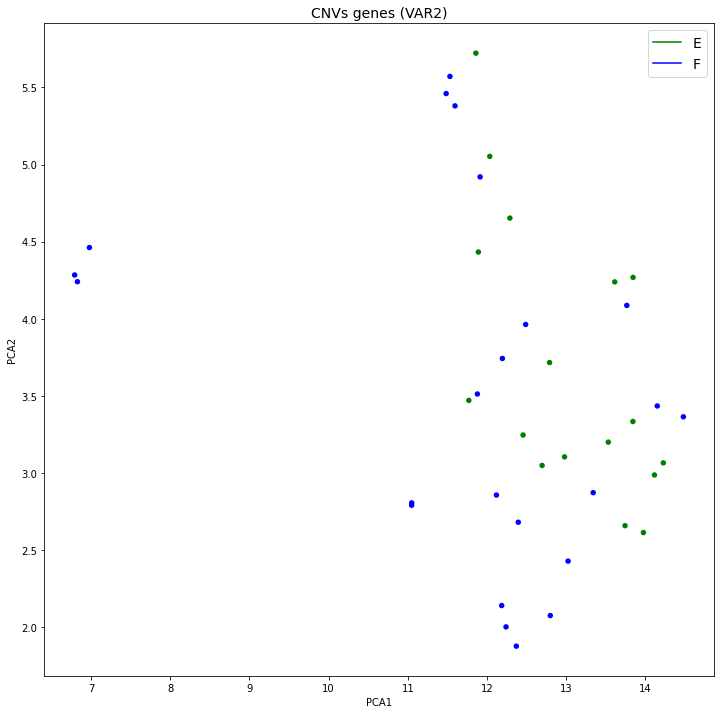

In [35]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import umap

meta = meta_filtered[meta_filtered['VAR2'].notnull()]
data = cnvs_genes.loc[:, meta.index.tolist()].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.fillna(2)

reduced_data = umap.UMAP(n_neighbors=5, min_dist=0.01, 
                         n_components=2, metric='cosine').fit_transform(data)

labels = [1 if x == 'E' else 2 for x in meta['VAR2']]
plot_scatter(x=reduced_data[:, 0], 
             y=reduced_data[:, 1], 
             colors=labels,
             labels=['E', 'F'],
             title='CNVs genes (VAR2)',
             filename='umap_var2.pdf')

In [36]:
set(meta['VAR4'])

{'CR', 'PD', 'PR', 'long SD'}

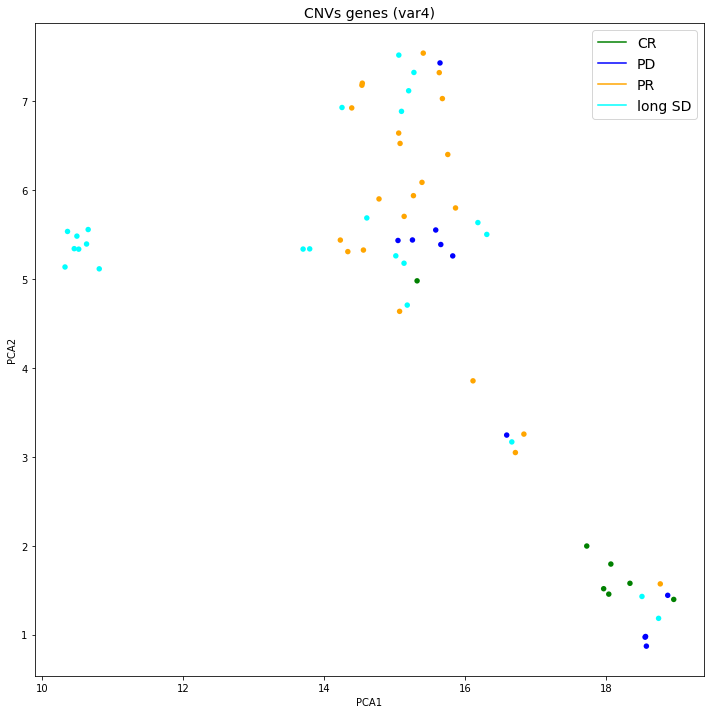

In [37]:
meta = meta_filtered[meta_filtered['VAR4'].notnull()]
data = cnvs_genes.loc[:, meta.index.tolist()].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.fillna(2)
data[data < 0] = 0
data = np.log1p(data)

reduced_data = umap.UMAP(n_neighbors=5, min_dist=0.01, 
                         n_components=2, metric='cosine').fit_transform(data)

var4 = meta['VAR4'].copy()
var4.loc[var4 == 'CR'] = 1
var4.loc[var4 == 'PD'] = 2
var4.loc[var4 == 'PR'] = 3
var4.loc[var4 == 'long SD'] = 4
var4.loc[var4 == 'short SD'] = 5
labels = ['CR', 'PD', 'PR', 'long SD', 'short SD']
plot_scatter(x=reduced_data[:, 0], 
             y=reduced_data[:, 1], 
             colors=var4.to_list(),
             labels=labels,
             title='CNVs genes (var4)',
             filename='umap_var4.pdf')